In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    
    plt.figure(dpi=200)
    if title is not None:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)
    plt.show()

In [3]:
epochs = 100

# CelebA Data

In [4]:
batch_size = 128

In [5]:
from data import CelebA
dataset = CelebA(transform=transforms.Compose([
                    transforms.CenterCrop(178),
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()]), label='male'
                 )

In [6]:
idcs = np.arange(len(dataset))
np.random.seed(0) # This is important to split the same way every single time
np.random.shuffle(idcs)
split_idx = int(0.9 * len(dataset))
train_idcs = idcs[:split_idx]
test_idcs = idcs[split_idx:]

In [7]:
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)

### Toggle cell below for sample debugging

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=16, shuffle=True, num_workers=4)

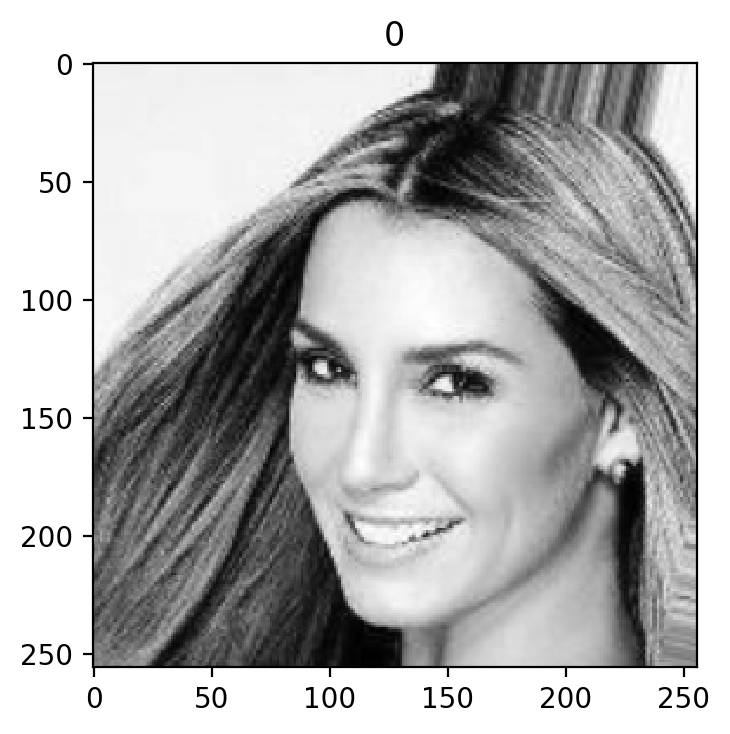

In [9]:
a_face, gender = dataset[0]
show(a_face, gender)

# Models

In [10]:
from models import FaderAE
from models import LatentDiscriminator

In [11]:
device = torch.device("cuda")

In [12]:
fader_auto_encoder = FaderAE(num_attributes=1).to(device)
latent_discriminator = LatentDiscriminator(latent_dimensionality=fader_auto_encoder.latent_space,
                                           num_attributes=1).to(device)

In [13]:
latent_discriminator

LatentDiscriminator(
  (fc1): Linear(in_features=50, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

In [14]:
from torch.autograd import Variable
def train(epoch):
    fader_auto_encoder.train()
    latent_discriminator.train()
    
    sum_latent_discriminator_loss = 0
    sum_fader_auto_encoder_loss = 0
    sum_fader_loss = 0
    
    latent_discriminator_penalization_weight = 1000

    for data_batch, label_batch in tqdm(train_loader):
        
        data_batch = data_batch.to(device)
        label_batch = label_batch.to(device).float()
        
        fader_auto_encoder.zero_grad()
        latent_discriminator.zero_grad()
        
        # Encode data
        z = fader_auto_encoder.encode(data_batch)
        
        # Compute discriminator loss
        z_in = Variable(z.data, requires_grad=False)
        latent_discriminator_predictions = latent_discriminator(z_in)
        latent_discriminator_loss = F.binary_cross_entropy(latent_discriminator_predictions, label_batch, reduction='sum')
        sum_latent_discriminator_loss += latent_discriminator_loss.item()

        # Train discriminator
        latent_discriminator_loss.backward(retain_graph=True)
        latent_discriminator.optimizer.step()
        
        # Compute discriminator penalization weight based on schedule
        c = 50
        if epoch < c:
            current_discriminator_penalization_weight = 0
        else:
            current_discriminator_penalization_weight = min(1, (epoch-c)/100)*latent_discriminator_penalization_weight

        # Compute auto encoder loss
        reconstructed_batch = fader_auto_encoder.decode(z, label_batch)
        fader_auto_encoder_loss = fader_auto_encoder.loss(reconstructed_batch, data_batch)
        sum_fader_auto_encoder_loss += fader_auto_encoder_loss.item()

        # Compute fader loss
        fader_loss = fader_auto_encoder_loss - current_discriminator_penalization_weight*latent_discriminator_loss
        sum_fader_loss += fader_loss.item()

        # Train auto encoder
        fader_loss.backward()
        fader_auto_encoder.optimizer.step()
        
    train_size = len(train_loader.dataset)

    print('====> Epoch: {} Fader Loss: {:.4f} | Auto Encoder Loss: {:.4f} | Latent Discriminator Loss: {:.4f} \n\t| Adjusted Latent Disc Loss: {:.4f}'.format(
          epoch, sum_fader_loss/train_size, sum_fader_auto_encoder_loss/train_size, 
        sum_latent_discriminator_loss/train_size, current_discriminator_penalization_weight*latent_discriminator_loss))


def test(epoch):
    print("Testing")
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in tqdm(enumerate(test_loader)):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += model.loss(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(batch_size, 1, 256, 256)[:n]])
#                 show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(epoch))

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

# Load

In [15]:
fader_auto_encoder_weight_path = 'weights/{}_{}.pt'.format(fader_auto_encoder.__class__.__name__, dataset.__class__.__name__)
fader_auto_encoder_weight_path

'weights/FaderAE_CelebA.pt'

In [16]:
epochs_trained_path = fader_auto_encoder_weight_path[:-3] + '_epochs.npy'
epochs_trained_path

'weights/FaderAE_CelebA_epochs.npy'

In [17]:
latent_discriminator_weight_path = 'weights/{}_{}.pt'.format(latent_discriminator.__class__.__name__, dataset.__class__.__name__)
latent_discriminator_weight_path

'weights/LatentDiscriminator_CelebA.pt'

In [18]:
import os

epochs_trained = 0
if os.path.exists(fader_auto_encoder_weight_path) and os.path.exists(latent_discriminator_weight_path) and os.path.exists(epochs_trained_path):
    fader_auto_encoder.load_state_dict(torch.load(fader_auto_encoder_weight_path))    
    latent_discriminator.load_state_dict(torch.load(latent_discriminator_weight_path))
    epochs_trained = np.load(epochs_trained_path)
    print("Loaded")
else:
    print("Starting from scratch")

Loaded


In [19]:
def save(epoch):
    torch.save(fader_auto_encoder.state_dict(), fader_auto_encoder_weight_path)
    torch.save(latent_discriminator.state_dict(), latent_discriminator_weight_path)
    np.save(epochs_trained_path, epoch)

# Train

  0%|          | 0/1425 [00:00<?, ?it/s]/data/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
100%|█████████▉| 1424/1425 [16:58<00:00,  1.38it/s]/data/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([68])) that is different to the input size (torch.Size([68, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
  0%|        

====> Epoch: 221 Fader Loss: 33722.9618 | Auto Encoder Loss: 34118.2397 | Latent Discriminator Loss: 0.3953 
	| Adjusted Latent Disc Loss: 21447.3301
Testing


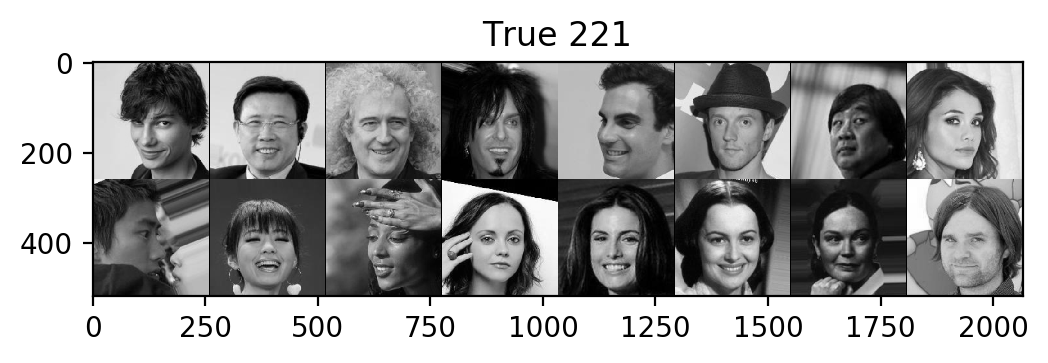

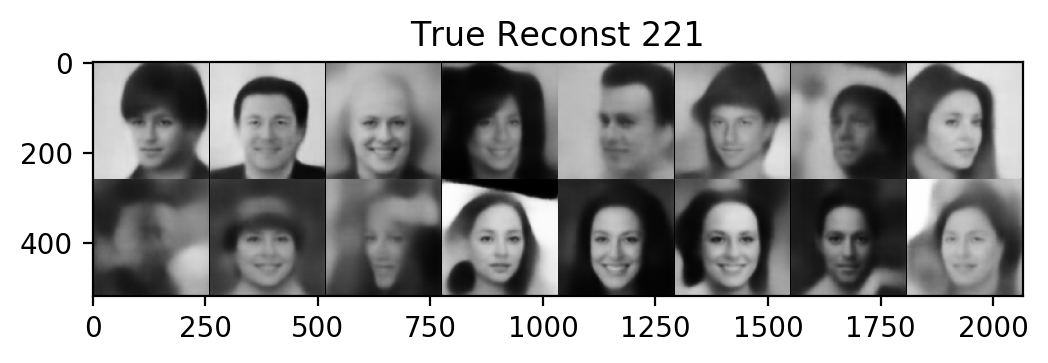

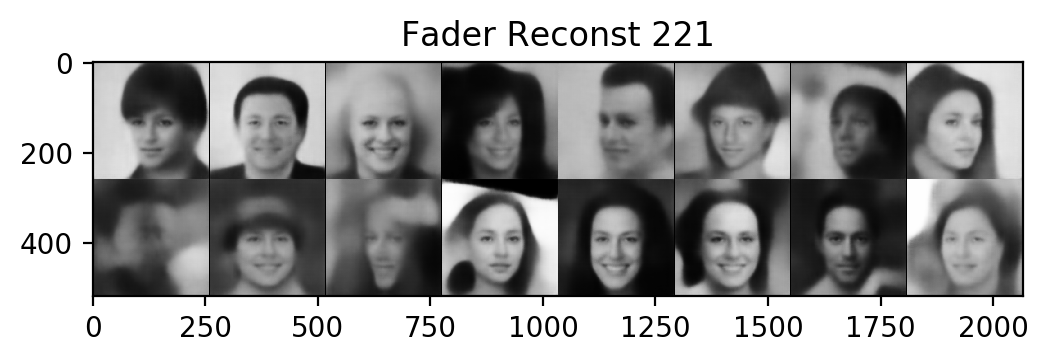


  0%|          | 0/1267 [00:00<?, ?it/s]

====> Epoch: 222 Fader Loss: 33697.2283 | Auto Encoder Loss: 34052.5065 | Latent Discriminator Loss: 0.3553 
	| Adjusted Latent Disc Loss: 19261.5059
Testing


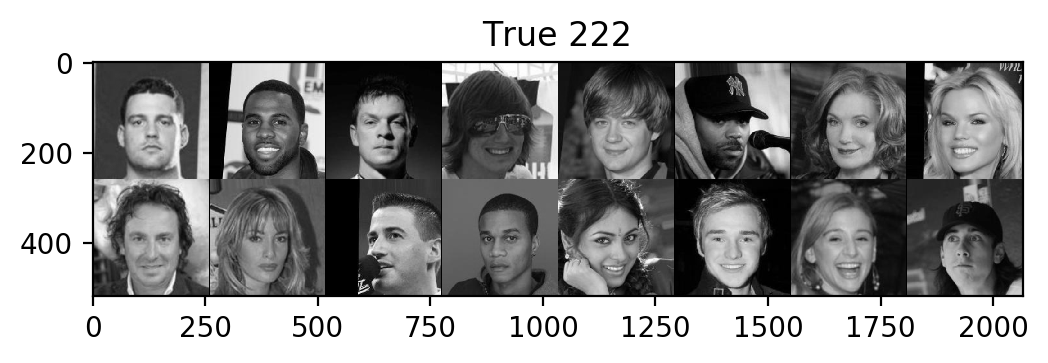

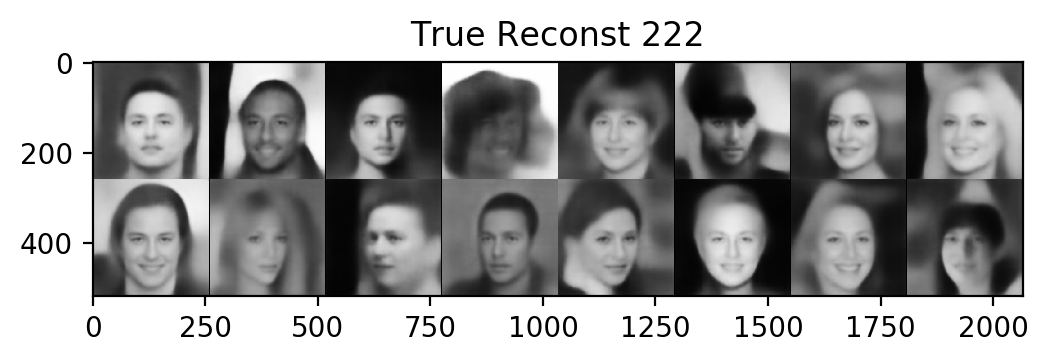

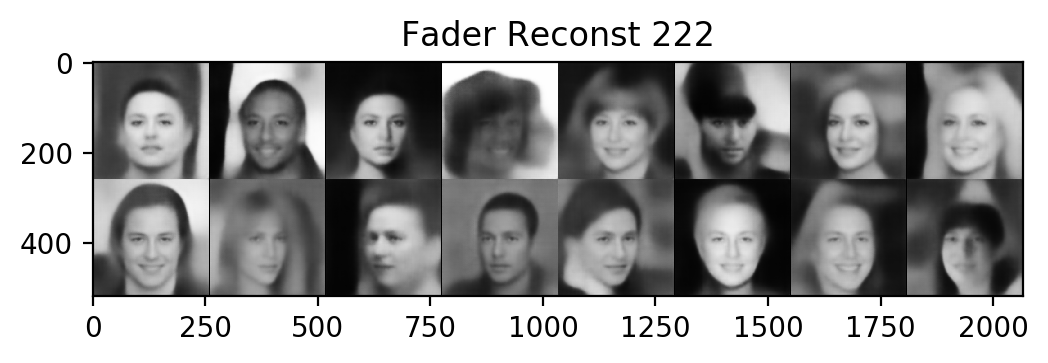


  8%|▊         | 114/1425 [01:22<15:44,  1.39it/s]

In [ ]:
%%time
for epoch in range(epochs_trained, epochs + epochs_trained):
    train(epoch)
    if epoch % 1 == 0:
        test(epoch)
        with torch.no_grad():
            for data_batch, label_batch in tqdm(test_loader):
                batch_size = data_batch.shape[0]

                data_batch = data_batch.to(device)
                label_batch = label_batch.to(device)
                
                batch_z = fader_auto_encoder.encode(data_batch)

                faders = torch.zeros(batch_size, 1).to(device)
                faders[batch_size // 2:][:] = 1
                
                show(make_grid(data_batch.detach().cpu()), 'True {}'.format(epoch))

                reconst = fader_auto_encoder.decode(batch_z, label_batch).cpu()
                show(make_grid(reconst.view(batch_size, 1, 256, 256)), 'True Reconst {}'.format(epoch))
                
                fader_reconst = fader_auto_encoder.decode(batch_z, faders).cpu()
                show(make_grid(fader_reconst.view(batch_size, 1, 256, 256)), 'Fader Reconst {}'.format(epoch))
                
                break
    save(epoch)